# Progetto di Algoritmi: EDA, PCA e Classificazione della specie di Iris

Questo notebook/script si articola in cinque sezioni:

1. **Exploratory Data Analysis (EDA)**
   - Statistiche descrittive
   - Istogrammi e scatter matrix
   - Heatmap di correlazione

2. **Preprocessing**
   - Standardizzazione delle feature (Z‑score)
   - Formula: $X' = \frac{X - \mu}{\sigma}$

3. **PCA (Principal Component Analysis) da zero**
   - Matrice di covarianza: $C = \frac{1}{n-1} X_{scaled}^T X_{scaled}$
   - Autovalori/autovettori di $C$
   - Spiegazione varianza: $\lambda_i / \sum_j \lambda_j$
   - Proiezione: $X_{pca} = X_{scaled} \cdot W$

4. **K-Means Iterativo**
   - Pseudocodice:
     ```
     Initialize k centroids randomly
     for t in 1..max_iter:
         Assign each point to nearest centroid (Euclidean distance)
         Update each centroid as mean of assigned points
         if centroids converged: break
     ```
   - Distanza Euclidea: $d(a,b)=\sqrt{\sum_i (a_i - b_i)^2}$

5. **Classificazione** (scaffolding)
   - k-NN:
     - Pseudocodice:
       ```
       for each test sample:
           compute d_i to tutti i campioni train
           seleziona k più vicini
           assegna label più frequente
       ```
   - Decision Tree (ID3):
     - Entropia: $H(Y) = -\sum_c p_c \log_2 p_c$
     - Gain: $IG = H(parent) - \sum_{branch} \frac{n_{branch}}{n} H(branch)$



'''

*caricamento librerie fondamentali*

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import math

**1. Caricamento dati e mappatura delle etichette**

In [5]:
PATH = "/Users/roberto/Downloads/Iris (1).csv"      

In [6]:
# Leggiamo Iris.csv, rimuoviamo ID e convertiamo le specie in numeri interi

df = pd.read_csv(PATH).drop(columns=['Id'])
species_map = {sp: i for i, sp in enumerate(df['Species'].unique())}
df['Species'] = df['Species'].map(species_map)
feature_names = df.columns[:-1]
X = df[feature_names].values
y = df['Species'].values


**2. Exploratory Data Analysis (EDA)**

In [7]:
# 2.1 Head e statistiche descrittive
print("--- Head of Dataset ---")
print(df.head(), "\n")
print("--- Descriptive Statistics ---")
print(df.describe(), "\n")

--- Head of Dataset ---
   SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm  Species
0            5.1           3.5            1.4           0.2        0
1            4.9           3.0            1.4           0.2        0
2            4.7           3.2            1.3           0.2        0
3            4.6           3.1            1.5           0.2        0
4            5.0           3.6            1.4           0.2        0 

--- Descriptive Statistics ---
       SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm     Species
count     150.000000    150.000000     150.000000    150.000000  150.000000
mean        5.843333      3.054000       3.758667      1.198667    1.000000
std         0.828066      0.433594       1.764420      0.763161    0.819232
min         4.300000      2.000000       1.000000      0.100000    0.000000
25%         5.100000      2.800000       1.600000      0.300000    0.000000
50%         5.800000      3.000000       4.350000      1.300000    1.0000

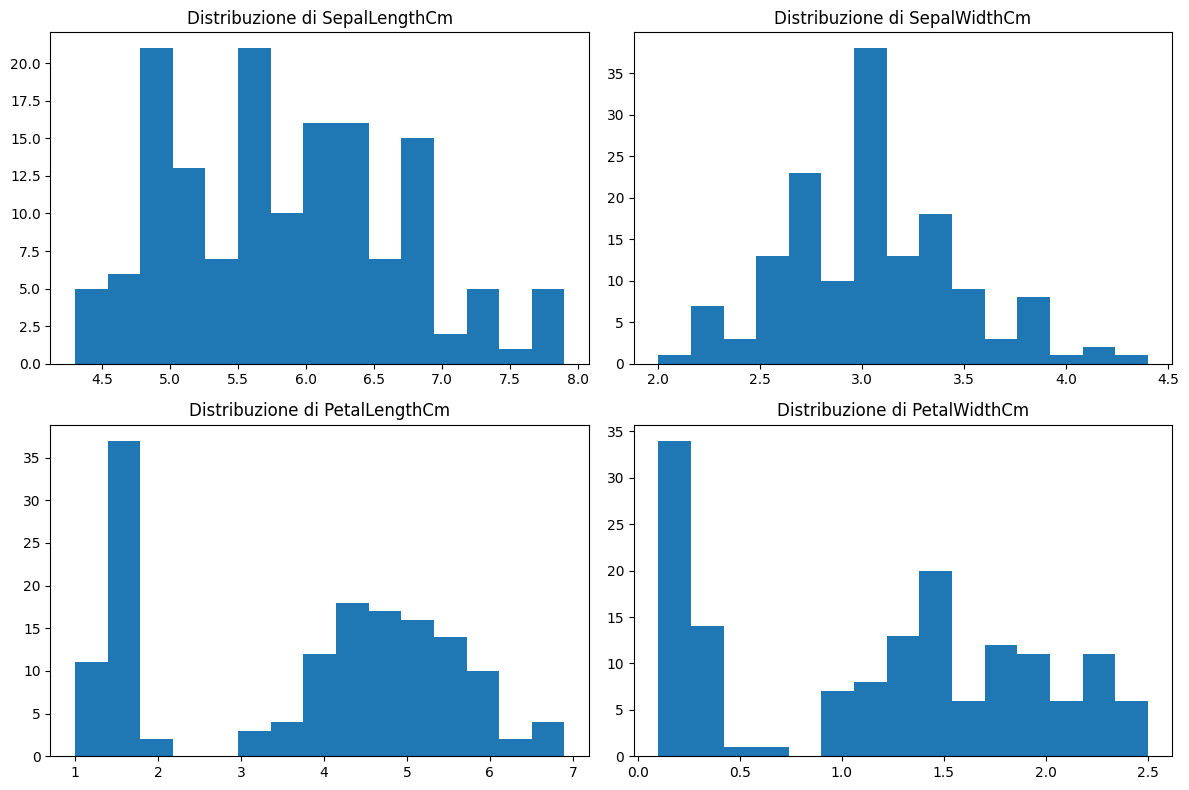

In [8]:
# 2.2 Istogrammi univariati
plt.figure(figsize=(12,8))
for i, col in enumerate(feature_names):
    plt.subplot(2,2,i+1)
    plt.hist(df[col], bins=15)
    plt.title(f"Distribuzione di {col}")
plt.tight_layout(); plt.show()

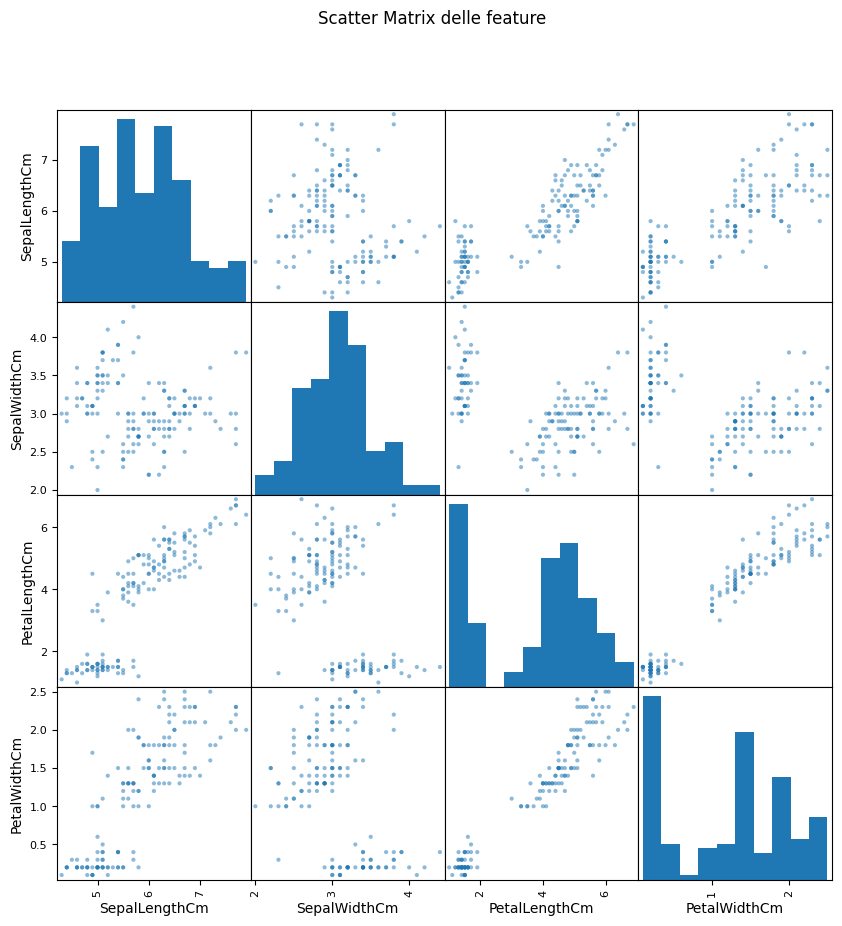

In [9]:
# 2.3 Scatter matrix (bivariata)
pd.plotting.scatter_matrix(df[feature_names], figsize=(10,10), diagonal='hist')
plt.suptitle("Scatter Matrix delle feature"); plt.show()

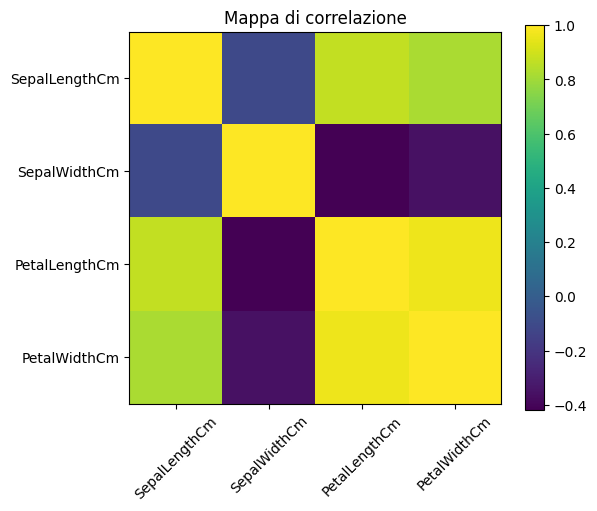

In [10]:
# 2.4 Heatmap di correlazione
corr = df[feature_names].corr()
plt.figure(figsize=(6,5))
plt.imshow(corr, cmap='viridis', interpolation='none')
plt.colorbar()
plt.xticks(range(len(feature_names)), feature_names, rotation=45)
plt.yticks(range(len(feature_names)), feature_names)
plt.title("Mappa di correlazione"); plt.show()

 **3. Preprocessing: Standardizzazione (Z-score)**

In [11]:
# Formula: X_scaled = (X - mean) / std

X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_scaled = (X - X_mean) / X_std

**4. PCA da zero**

In [12]:
# 4.1 Matrice di covarianza
cov_mat = np.cov(X_scaled, rowvar=False)

# 4.2 Calcolo autovalori e autovettori
#    C v = λ v

eigen_vals, eigen_vecs = np.linalg.eigh(cov_mat)

# 4.3 Ordinamento in ordine decrescente di λ
idxs = np.argsort(eigen_vals)[::-1]
eigen_vals = eigen_vals[idxs]
eigen_vecs = eigen_vecs[:, idxs]

# 4.4 Spiegazione della varianza
explained_var = eigen_vals / eigen_vals.sum()
cum_explained = np.cumsum(explained_var)
print("Explained variance ratio:", np.round(explained_var,3))
print("Cumulative explained variance:", np.round(cum_explained,3))

# 4.5 Proiezione sulle prime 2 componenti principali
W2 = eigen_vecs[:, :2]              # matrice di proiezione (p x 2)
X_pca2 = X_scaled.dot(W2)           # trasformazione dei dati (n x 2)

Explained variance ratio: [0.728 0.23  0.037 0.005]
Cumulative explained variance: [0.728 0.958 0.995 1.   ]


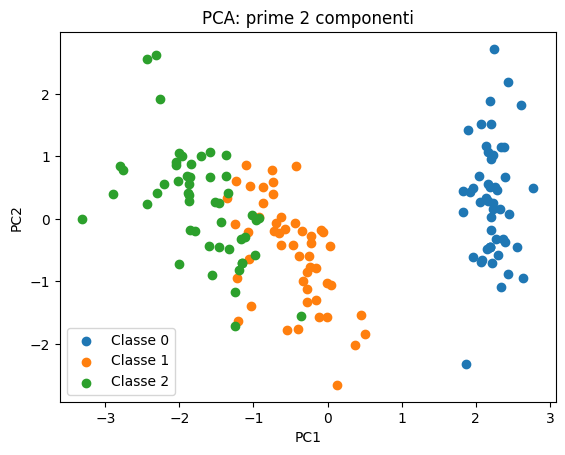

In [13]:
plt.figure()
for cls in np.unique(y):
    plt.scatter(X_pca2[y==cls,0], X_pca2[y==cls,1], label=f"Classe {cls}")
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.title('PCA: prime 2 componenti'); plt.legend(); plt.show()

**5. K-Means iterativo con tracking delle iterazioni**

In [14]:
class KMeansIter:
    """
    Implementazione di K-Means con salvataggio di centroidi e label ad ogni iterazione.

    Pseudocodice:
        Initialize centroids randomly
        for t in range(max_iter):
            assign each x to nearest centroid
            compute new centroids = mean of points per cluster
            if centroids unchanged: break
    """
    def __init__(self, k=3, max_iter=10):
        self.k = k
        self.max_iter = max_iter
        self.centroids_history = []
        self.labels_history = []
    def fit(self, X):
        n = X.shape[0]
        # 1) inizializza centroidi
        idx = np.random.choice(n, self.k, replace=False)
        centroids = X[idx]
        # iterazioni
        for it in range(self.max_iter):
            self.centroids_history.append(centroids.copy())
            # 2) assegnazione (min d Euclidea)
            labels = np.array([
                np.argmin([np.linalg.norm(x - c) for c in centroids])
                for x in X
            ])
            self.labels_history.append(labels)
            # 3) aggiornamento centroidi
            new_centroids = np.array([
                X[labels==i].mean(axis=0) if np.any(labels==i) else centroids[i]
                for i in range(self.k)
            ])
            # 4) convergenza?
            if np.allclose(new_centroids, centroids):
                break
            centroids = new_centroids
        self.centroids = centroids


*Funzione di plot per visualizzare iterazione specifica*

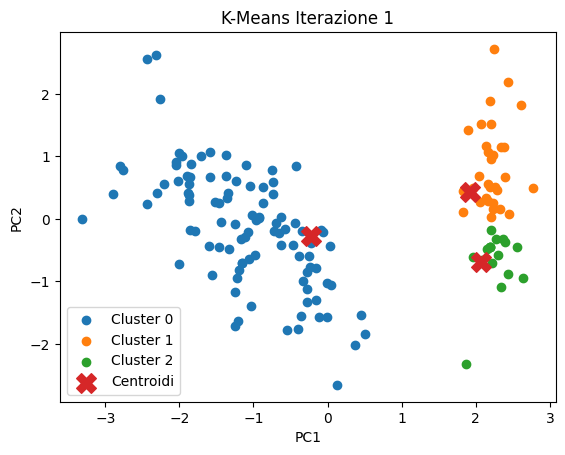

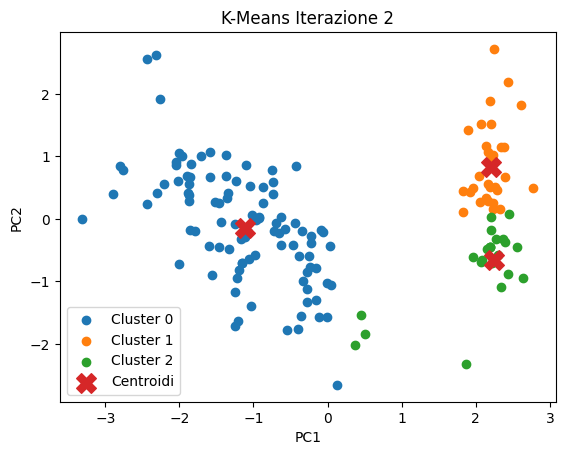

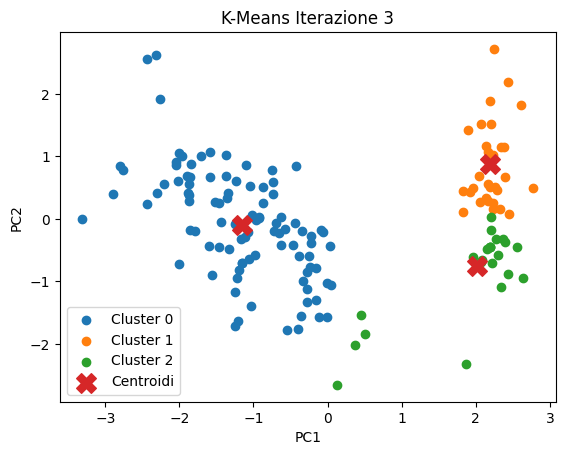

In [17]:
def plot_kmeans_iter(X, kmi, iter_idx, feat=(0,1)):
    cent = kmi.centroids_history[iter_idx]
    lab = kmi.labels_history[iter_idx]
    plt.figure()
    for i in range(kmi.k):
        plt.scatter(X[lab==i, feat[0]], X[lab==i, feat[1]], label=f"Cluster {i}")
    plt.scatter(cent[:,feat[0]], cent[:,feat[1]], marker='X', s=200, label='Centroidi')
    plt.title(f"K-Means Iterazione {iter_idx+1}")
    plt.xlabel('PC1'); plt.ylabel('PC2'); plt.legend(); plt.show()

# Eseguiamo e mostriamo prime 3 iterazioni nello spazio PCA
kmi = KMeansIter(k=3, max_iter=5)
kmi.fit(X_pca2)
for i in range(min(3, len(kmi.centroids_history))):
    plot_kmeans_iter(X_pca2, kmi, i)

# =============================================================================
# 6. Scaffolding per classificazione finale
# =============================================================================
# k-NN e Decision Tree (ID3) verranno applicati sui dataset X_scaled o X_pca2.
# Le formule principali:
#   - Distanza: d(a,b)=sqrt(sum((a-b)^2))
#   - Entropia: H(Y) = -sum(p_c log2 p_c)\#   - Information Gain come definito in ID3
# Inserire qui le classi KNNClassifier e DecisionTreeClassifier come visto in precedenza.

# Fine del progetto: ora possiamo selezionare i modelli e parametrizzarli sulla base dell'EDA/PCA.
